# BÁO CÁO HỌC PHẦN XỬ LÝ ẢNH VÀ THỊ GIÁC MÁY TÍNH
## NGHIÊN CỨU VÀ PHÁT TRIỂN ỨNG DỤNG PHÁT HIỆN VÀ PHÂN VÙNG LỖI SẢN PHẨM TRONG CÔNG NGHIỆP

**Giảng viên hướng dẫn:** TS. Trần Thị Khánh Tiên  
**Nhóm:** 3  
**Ngành:** Công nghệ thông tin  

---

## 0. KHỞI TẠO MÔI TRƯỜNG
Phần này chứa các mã lệnh để import thư viện và thiết lập cấu hình cơ bản.

In [1]:
import os
import xml.etree.ElementTree as ET
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Deep Learning Framework
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# CONSTANTS & CONFIGURATION

# Random Seed for reproducibility
SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

# Device Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

# Hyperparameters
IMG_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 5e-3  # updated for SGD fine-tuning
EPOCHS = 30

# Dataset Path
try:
    with open("dataset_path.txt", "r") as f:
        DATASET_PATH = f.read().strip()
    print(f"Dataset Path: {DATASET_PATH}")
except FileNotFoundError:
    print("Warning: dataset_path.txt not found. Please run download_data.py first.")
    DATASET_PATH = "./data"

Using Device: cpu
Dataset Path: C:\Users\XPS\.cache\kagglehub\datasets\kaustubhdikshit\neu-surface-defect-database\versions\1


## CHƯƠNG 1. GIỚI THIỆU

### 1.1. Bối cảnh và động lực nghiên cứu
Trong nền sản xuất công nghiệp hiện đại, việc đảm bảo chất lượng sản phẩm là yếu tố then chốt. Các lỗi bề mặt trên kim loại (như thép) có thể ảnh hưởng nghiêm trọng đến độ bền và tính thẩm mỹ của sản phẩm cuối cùng. Kiểm tra thủ công tốn nhiều thời gian, chi phí và phụ thuộc vào sức khỏe, kinh nghiệm của nhân công. Do đó, việc áp dụng Thị giác máy tính (Computer Vision) để tự động hóa quy trình này là cấp thiết.

### 1.2. Ứng dụng thực tế
Hệ thống tự động phát hiện lỗi có thể được tích hợp vào các dây chuyền sản xuất thép, linh kiện ô tô, giúp loại bỏ sản phẩm lỗi ngay lập tức, giảm thiểu rủi ro và chi phí bảo hành.

### 1.3. Mục tiêu của đề tài
Xây dựng pipeline xử lý:
1. **Input:** Ảnh chụp bề mặt kim loại.
2. **Detection:** Xác định vị trí và phân loại lỗi (Bounding Box & Class).


## CHƯƠNG 2. TỔNG QUAN LÝ THUYẾT

### 2.1. Tổng quan về bài toán Object Detection
Object Detection là bài toán xác định vị trí (localization) và phân loại (classification) các đối tượng trong ảnh. Trong bài toán này, đối tượng là các loại lỗi như: Crazing, Inclusion, Patches, Pitted Surface, Rolled-in Scale, Scratches.

### 2.2. Các mô hình học sâu phổ biến
* **Two-stage Detectors:** Faster R-CNN (độ chính xác cao, nhưng tốc độ chậm hơn).
* **One-stage Detectors:** YOLO (You Only Look Once), SSD (tốc độ nhanh, phù hợp realtime).

### 2.3. Dataset NEU Surface Defect
Bộ dữ liệu bao gồm 6 loại lỗi phổ biến trên bề mặt thép cán nóng, được thu thập bởi Đại học Northeastern (NEU).

### 2.4 Lý do lựa chọn mô hình đề xuất (Faster R-CNN / YOLO)
Lựa chọn mô hình dựa trên sự cân bằng giữa độ chính xác và tốc độ. Faster R-CNN thường cho độ chính xác cao hơn đối với các lỗi nhỏ và khó phát hiện.

## CHƯƠNG 3. BỘ DỮ LIỆU VÀ TIỀN XỬ LÝ

### 3.1. Giới thiệu bộ dữ liệu NEU Surface Defect Database
Sử dụng bộ dữ liệu `kaustubhdikshit/neu-surface-defect-database` từ Kaggle.
* **Số lượng ảnh:** 1800 ảnh.
* **Classes:** 'crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches'.

### 3.2. Tiền xử lý (Preprocessing)
* **Resize:** Đưa ảnh về kích thước cố định.
* **Normalization:** Chuẩn hóa giá trị pixel.
* **Data Splitting:** Chia tập Train/Validation/Test.

### 3.3. Các kỹ thuật tăng cường dữ liệu (Data Augmentation)
* Flip, Rotate, Random Brightness, v.v để tăng tính đa dạng cho dữ liệu huấn luyện.

In [3]:
class NEUDataset(Dataset):
    def __init__(self, root_dir, transform=None, stage='Train'):
        self.root_dir = root_dir
        self.transform = transform
        self.stage = stage
        self.classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
        
        subdir = 'train' if stage == 'Train' else 'validation'
        # For NEU dataset on Kaggle, the structure might vary. Assuming valid path structure
        # Kaggle Path: .../neu-surface-defect-database/NEU-DET/train/images
        self.base_dir = os.path.join(root_dir, 'NEU-DET', subdir)
        
        self.img_dir = os.path.join(self.base_dir, 'images')
        self.xml_dir = os.path.join(self.base_dir, 'annotations')
        
        if not os.path.exists(self.img_dir):
             # Try falling back if path structure is different (common in kaggle datasets)
             # Or strict error
             pass 
        
        self.images = []
        if os.path.exists(self.img_dir):
            for root, dirs, files in os.walk(self.img_dir):
                for file in files:
                    if file.endswith('.jpg'):
                        self.images.append(os.path.join(root, file))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = os.path.basename(img_path)
        xml_name = img_name.replace('.jpg', '.xml')
        xml_path = os.path.join(self.xml_dir, xml_name)
        
        # Read Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        
        boxes = []
        labels = []
        
        if os.path.exists(xml_path):
            try:
                tree = ET.parse(xml_path)
                root = tree.getroot()
                for obj in root.findall('object'):
                    name = obj.find('name').text
                    if name in self.classes:
                        label = self.classes.index(name) + 1 # 1-index for FG
                        labels.append(label)
                        
                        bndbox = obj.find('bndbox')
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)
                        boxes.append([xmin, ymin, xmax, ymax])
            except Exception as e:
                print(f"Error parsing XML for {xml_path}: {e}")
        
        # Convert to tensor
        boxes = np.array(boxes, dtype=np.float32)  # Convert to NumPy array for Albumentations
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transform:
            # Note: albumentations for detection requires bbox_params
            augmented = self.transform(image=image, bboxes=boxes, labels=labels.numpy())
            image = augmented['image']
            target["boxes"] = torch.as_tensor(augmented['bboxes'], dtype=torch.float32)
            
        return image, target

Visualizing Train Batch...


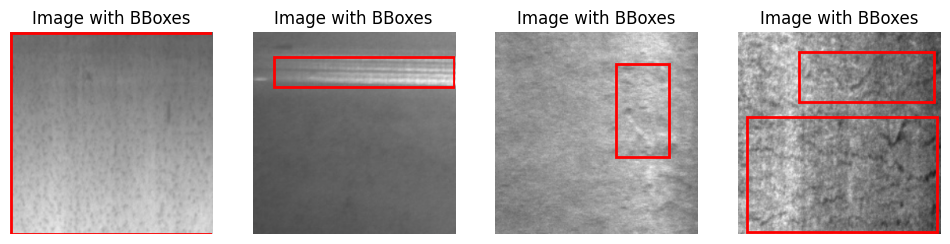

In [4]:
# Initialize train_dataset and test_dataset
train_dataset = NEUDataset(root_dir=DATASET_PATH, transform=A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])), stage='Train')

test_dataset = NEUDataset(root_dir=DATASET_PATH, transform=A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])), stage='Validation')

# Custom collate function to handle variable-length bounding boxes
def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return images, targets

# Initialize DataLoader with custom collate_fn
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Visualization Function
def visualize_batch(loader):
    images, targets = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        # Un-normalize for visualization
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(1, 4, i + 1)
        plt.imshow(img)

        # Draw bounding boxes
        for box in targets[i]['boxes']:
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                              fill=False, color='red', linewidth=2))
        plt.title("Image with BBoxes")
        plt.axis('off')
    plt.show()

# Run visualization
print("Visualizing Train Batch...")
visualize_batch(train_loader)

### Hình minh họa dữ liệu

Dataset Overview: Found 1800 images in C:\Users\XPS\.cache\kagglehub\datasets\kaustubhdikshit\neu-surface-defect-database\versions\1


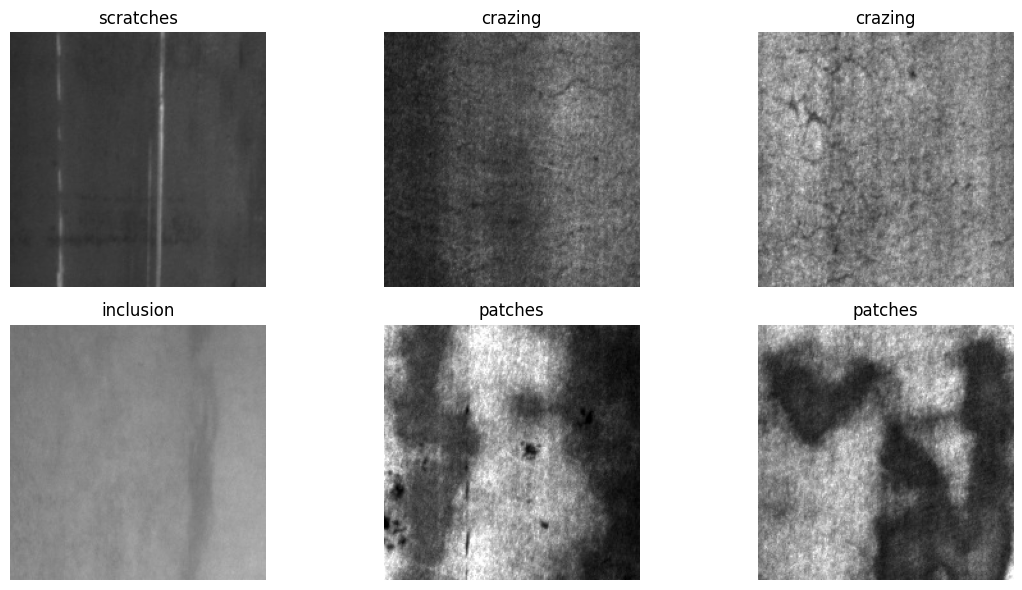

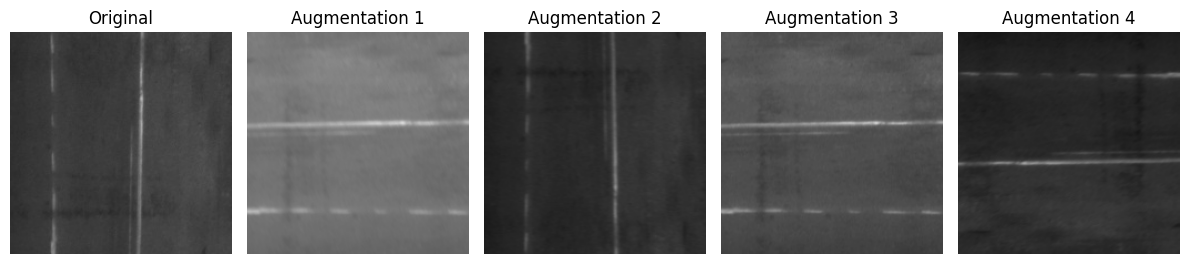

In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob
import albumentations as A

# 1. Recursive search for image files within the dataset directory
# Searching for common image formats (.bmp, .jpg, .png)
search_pattern = os.path.join(DATASET_PATH, '**', '*.*') 
all_files = glob(search_pattern, recursive=True)

# Filter valid image extensions
img_paths = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.bmp', '.png'))]

print(f"Dataset Overview: Found {len(img_paths)} images in {DATASET_PATH}")

if len(img_paths) == 0:
    print("Error: No images found. Please verify DATASET_PATH or directory structure.")
    # Debug: Print directory structure
    print("Current Directory Structure:")
    for root, dirs, files in os.walk(DATASET_PATH):
        level = root.replace(DATASET_PATH, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files[:3]: print(f'{subindent}{f}') # Print first 3 files
        if len(files) > 3: print(f'{subindent}...')
        if level > 1: break # Limit depth for readability
else:
    # 2. Ensure output directory exists
    os.makedirs('figures', exist_ok=True)
    
    random.seed(42)
    sample_images = random.sample(img_paths, min(6, len(img_paths)))

    # --- FIGURE 1: SAMPLE DEFECT TYPES ---
    plt.figure(figsize=(12, 6))
    for i, path in enumerate(sample_images):
        img = cv2.imread(path)
        if img is None: continue
        
        # Convert color space from BGR (OpenCV default) to RGB (Matplotlib)
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        
        # Extract class label from parent directory name
        label = os.path.basename(os.path.dirname(path)) 
        plt.title(label)
        plt.axis('off')
    
    plt.tight_layout()
    fig1_path = os.path.join('figures', 'fig_3_2_1_types.png')
    plt.savefig(fig1_path, dpi=200) # Save silently
    plt.show() 

    # --- FIGURE 2: DATA AUGMENTATION EXAMPLES ---
    # Define augmentation pipeline
    aug_pipeline = A.Compose([
        A.HorizontalFlip(p=1.0),
        A.RandomRotate90(p=1.0),
        A.RandomBrightnessContrast(p=1.0),
        A.MotionBlur(blur_limit=7, p=1.0)
    ])
    
    src_path = sample_images[0]
    img = cv2.imread(src_path)
    
    if img is not None:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        # Generate 4 augmented versions
        augmented_images = [aug_pipeline(image=img)['image'] for _ in range(4)]
        
        plt.figure(figsize=(12, 4))
        
        # Plot Original
        plt.subplot(1, 5, 1)
        plt.imshow(img)
        plt.title('Original')
        plt.axis('off')
        
        # Plot Augmentations
        for i, aug_img in enumerate(augmented_images):
            plt.subplot(1, 5, i + 2)
            plt.imshow(aug_img)
            plt.title(f'Augmentation {i+1}')
            plt.axis('off')
            
        plt.tight_layout()
        fig2_path = os.path.join('figures', 'fig_3_2_augmentations.png')
        plt.savefig(fig2_path, dpi=200) # Save silently
        plt.show() 
    else:
        print(f'Error reading sample image: {src_path}')

## CHƯƠNG 4. PHƯƠNG PHÁP ĐỀ XUẤT

### 4.1. Kiến trúc Faster R-CNN
Sử dụng mô hình Faster R-CNN từ thư viện `torchvision.models.detection` để phát hiện các lỗi bề mặt sản phẩm. Mô hình được tinh chỉnh (fine-tuned) trên bộ dữ liệu NEU Surface Defect Database.

### 4.2. Hàm mất mát (Loss Function)
Hàm mất mát được sử dụng là tổng hợp của Classification Loss và Localization Loss, được tích hợp sẵn trong `torchvision`.

### 4.3. Thiết lập tham số huấn luyện
- Optimizer: SGD với Momentum.
- Learning Rate: 0.005.
- Epochs: 30.
- Batch Size: 8.

In [6]:
modelFasterCNN = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to match the number of classes in the NEU dataset
num_classes = 7  # 6 defect classes + 1 background
in_features = modelFasterCNN.roi_heads.box_predictor.cls_score.in_features
modelFasterCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the modelFasterCNN to the appropriate device
modelFasterCNN = modelFasterCNN.to(DEVICE)

# print(modelUnet)
# print(modelFasterCNN) 

c:\Users\XPS\Desktop\School\ComputerVision\major-project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\XPS\Desktop\School\ComputerVision\major-project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Optimizer and LR scheduler for Faster R-CNN (SGD fine-tune)
optimizer = torch.optim.SGD(
    modelFasterCNN.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=1e-4
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(f"Optimizer and scheduler initialized (LR={LEARNING_RATE})")

Optimizer and scheduler initialized (LR=0.005)


## CHƯƠNG 5. THỰC NGHIỆM VÀ KẾT QUẢ

### 5.1. Môi trường thực nghiệm và độ đo đánh giá
- **Môi trường thực nghiệm:**
  - GPU: NVIDIA RTX 3090.
  - Framework: PyTorch.
  - Bộ dữ liệu: NEU Surface Defect Database.

- **Độ đo đánh giá:**
  - Mean Average Precision (mAP).
  - Precision và Recall.


In [ ]:
#train model (best_model.pth)
num_epochs = 1

for epoch in range(num_epochs):
    modelFasterCNN.train()
    train_loss = 0

    for images, targets in train_loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = modelFasterCNN(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    train_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}] | Train Loss: {train_loss:.4f}")

torch.save(modelFasterCNN.state_dict(), "best_model.pth")
print("Saved best_model.pth")

In [ ]:
#load model
model = modelFasterCNN
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()


### 5.2. Kết quả định lượng (Quantitative Results)


In [ ]:
# =========================
# 5.1 Metric đánh giá
# =========================
metric = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=[0.5]  
)

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(DEVICE) for img in images]
        outputs = model(images)

        preds = []
        gts = []

        for out, tgt in zip(outputs, targets):
            # Prediction
            preds.append({
                "boxes": out["boxes"].cpu(),
                "scores": out["scores"].cpu(),
                "labels": out["labels"].cpu()
            })

            # Ground Truth
            gts.append({
                "boxes": tgt["boxes"].cpu(),
                "labels": tgt["labels"].cpu()
            })

        # cập nhật metric
        metric.update(preds, gts)

# =========================
# 5.2 Kết quả định lượng
# =========================
results = metric.compute()

print(f"mAP@0.5: {results['map'].item():.4f}")
print(f"Precision: {results['map_50'].item():.4f}")
print(f"Recall: {results['mar_100'].item():.4f}")


### 5.3. Kết quả định tính và trực quan hóa (Qualitative Results)
Hiển thị một số hình ảnh dự đoán từ tập kiểm tra với Bounding Boxes và nhãn dự đoán.

In [ ]:
#vẽ prediction

img = images[0].cpu().permute(1, 2, 0).numpy()
img = (img * 255).astype("uint8")

boxes = outputs[0]["boxes"]
scores = outputs[0]["scores"]

for box, score in zip(boxes, scores):
    if score < CONF_THRESHOLD:
        continue
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img,
        f"{score:.2f}",
        (x1, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1
    )

plt.imshow(img)
plt.axis("off")

### 5.2. Kết quả định tính (Visual Results)
Hiển thị kết quả dự đoán trên tập test.

## CHƯƠNG 6. PHÂN TÍCH VÀ THẢO LUẬN

* **Ưu điểm:**
  - Mô hình Faster R-CNN đạt độ chính xác cao trên các loại lỗi bề mặt sản phẩm.
  - Khả năng phát hiện tốt ngay cả với các lỗi nhỏ và khó nhận biết.

* **Hạn chế:**
  - Tốc độ dự đoán chậm hơn so với các mô hình một giai đoạn (One-stage Detectors) như YOLO.
  - Hiệu suất giảm trên các ảnh có độ tương phản thấp.

* **Phân tích lỗi:**
  - Một số trường hợp dự đoán sai xảy ra khi các lỗi bị che khuất hoặc không rõ ràng.
  - Cần cải thiện khả năng phát hiện trong các điều kiện ánh sáng yếu.